   Subgroup  Student Data Count  LLM Data Count
MX       MX                  17              17
EM       EM                  13              13
PS       PS                  12              12
SE       SE                   8               8
MS       MS                   7               7
FN       FN                   7               7
VB       VB                   6               6
LF       LF                   5               5
ME       ME                   5               5
ST       ST                   4               4
II       II                   3               3
LP       LP                   1               1


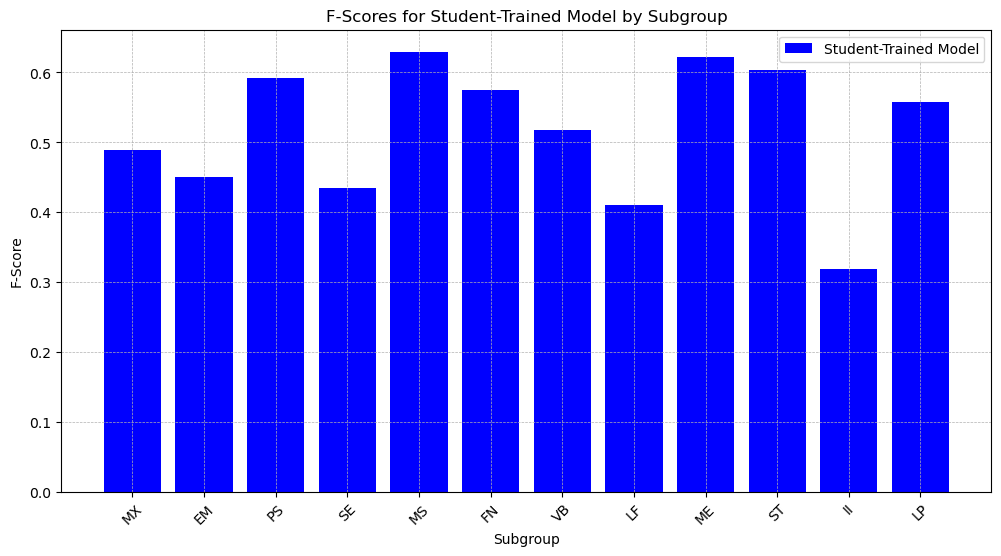

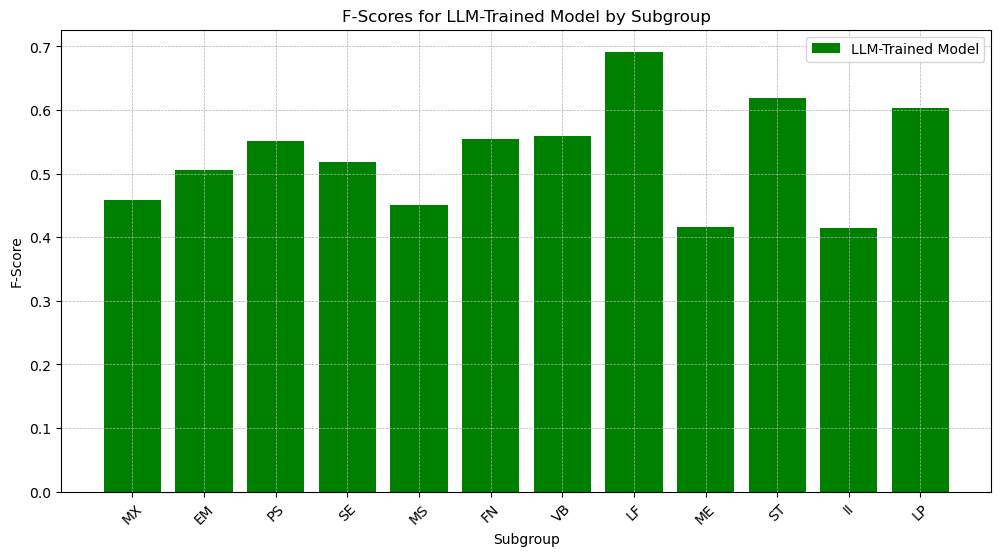

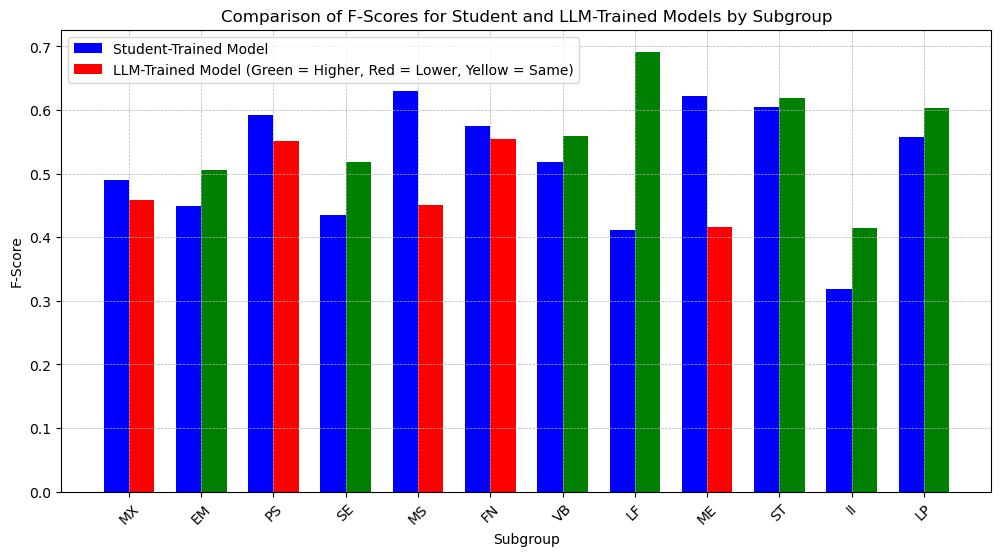

   Subgroup  Student-Trained F-Score  LLM-Trained F-Score
5        MX                 0.489660             0.459137
2        EM                 0.449911             0.505811
6        PS                 0.592121             0.551715
7        SE                 0.434224             0.518043
3        MS                 0.629814             0.451356
10       FN                 0.575470             0.554809
1        VB                 0.517669             0.559813
0        LF                 0.410760             0.691900
9        ME                 0.622483             0.415977
11       ST                 0.604138             0.619187
8        II                 0.318618             0.413932
4        LP                 0.557386             0.603861


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import re

# sklearn-warnings unterdrücken
warnings.filterwarnings("ignore", category=UserWarning)

# Relative Pfade zu den Ordnern
student_data_folder = 'Data_SRA'  # Ordner mit TSV-Dateien
llm_data_folder = 'Data_LLM'      # Ordner mit CSV-Dateien

# Funktion zur Extraktion der Untergruppen
def extract_subgroup(file_name):
    match = re.search(r'prompt([A-Z]{2})', file_name)
    return match.group(1) if match else None

# Liste aller TSV-Dateien im Ordner 'Data_SRA'
student_data_files = [os.path.join(student_data_folder, file) for file in os.listdir(student_data_folder) if file.endswith('.tsv')]

# Liste aller CSV-Dateien im Ordner 'Data_LLM'
llm_data_files = [os.path.join(llm_data_folder, file) for file in os.listdir(llm_data_folder) if file.endswith('.csv')]

# Untergruppen extrahieren
student_subgroups = [extract_subgroup(file) for file in os.listdir(student_data_folder) if file.endswith('.tsv')]
llm_subgroups = [extract_subgroup(file) for file in os.listdir(llm_data_folder) if file.endswith('.csv')]

# Zähle die Häufigkeit der Untergruppen
student_subgroup_counts = pd.Series(student_subgroups).value_counts()
llm_subgroup_counts = pd.Series(llm_subgroups).value_counts()

# Kombiniere die Häufigkeiten in einem DataFrame
subgroup_summary = pd.DataFrame({
    'Subgroup': student_subgroup_counts.index,
    'Student Data Count': student_subgroup_counts.values,
    'LLM Data Count': llm_subgroup_counts.reindex(student_subgroup_counts.index, fill_value=0)  # Null auffüllen, falls nicht vorhanden
})

# Ausgabe der Untergruppenzählungen
print(subgroup_summary)

# Listen, um die F-Scores zu speichern
f_scores_student_model = []
f_scores_llm_model = []

# F-Scores für jede Untergruppe speichern
subgroup_f_scores_student = {}
subgroup_f_scores_llm = {}

for student_file, llm_file in zip(student_data_files, llm_data_files):
    # Daten laden
    data_student = pd.read_csv(student_file, sep="\t")  # TSV-Dateien
    data_llm = pd.read_csv(os.path.join(llm_data_folder, student_file.split('/')[1][:-3] + 'csv'))    

    # Text preprocessing und Vektorisierung
    vectorizer = TfidfVectorizer()
    X_student = vectorizer.fit_transform(data_student['AnswerText'])
    X_llm = vectorizer.transform(data_llm['AnswerText'])

    y_student = data_student['Score']
    y_llm = data_llm['Score']

    # Einzigartige Labels extrahieren
    all_labels = set(data_student['Score']).union(set(data_llm['Score']))
    sorted_labels = sorted(all_labels)
    label_mapping = {label: index for index, label in enumerate(sorted_labels)}

    # Label-Mapping anwenden
    y_student_mapped = y_student.map(label_mapping)
    y_llm_mapped = y_llm.map(label_mapping)

    # Teil 1: Trainieren auf Studentendaten, Testen auf Studentendaten mit Leave-One-Out
    loo = LeaveOneOut()

    predictions_student = []  # Vorhersagen für den Studenten-Trainingslauf
    true_labels_student = []  # Wahre Labels

    for train_index, test_index in loo.split(X_student):
        X_train, X_test = X_student[train_index], X_student[test_index]
        y_train, y_test = y_student_mapped.iloc[train_index], y_student_mapped.iloc[test_index]

        svm_model_student = SVC(kernel='rbf')
        svm_model_student.fit(X_train, y_train)
        y_pred = svm_model_student.predict(X_test)

        # Speichere die Vorhersagen und wahren Labels
        predictions_student.append(y_pred[0])
        true_labels_student.append(y_test.iloc[0])

    # Berechne den F1-Score nach der LOO-Schleife für das Studentenmodell
    f1_student = f1_score(true_labels_student, predictions_student, average='weighted', zero_division=0)
    f_scores_student_model.append(f1_student)

    # Speichere den F1-Score in der Untergruppendatenstruktur
    subgroup_key = extract_subgroup(student_file.split('/')[-1])
    if subgroup_key not in subgroup_f_scores_student:
        subgroup_f_scores_student[subgroup_key] = []
    subgroup_f_scores_student[subgroup_key].append(f1_student)

    # Teil 2: Trainieren auf LLM-Daten, Testen auf Studentendaten mit Leave-One-Out
    predictions_llm = []  # Vorhersagen für den LLM-Trainingslauf
    true_labels_llm = []  # Wahre Labels (Studentendaten als Testdaten)

    for train_index, test_index in loo.split(X_student):
        X_train_llm, X_test = X_llm, X_student[test_index]
        y_train_llm, y_test = y_llm_mapped, y_student_mapped.iloc[test_index]

        svm_model_llm = SVC(kernel='rbf')
        svm_model_llm.fit(X_train_llm, y_train_llm)
        y_pred_llm = svm_model_llm.predict(X_test)

        # Speichere die Vorhersagen und wahren Labels
        predictions_llm.append(y_pred_llm[0])
        true_labels_llm.append(y_test.iloc[0])

    # Berechne den F1-Score nach der LOO-Schleife für das LLM-Modell
    f1_llm = f1_score(true_labels_llm, predictions_llm, average='weighted', zero_division=0)
    f_scores_llm_model.append(f1_llm)

    # Speichere den F1-Score in der Untergruppendatenstruktur
    subgroup_key = extract_subgroup(llm_file.split('/')[-1])
    if subgroup_key not in subgroup_f_scores_llm:
        subgroup_f_scores_llm[subgroup_key] = []
    subgroup_f_scores_llm[subgroup_key].append(f1_llm)

# Berechne den Durchschnitt der F-Scores für jede Untergruppe
average_student_scores = {k: np.mean(v) for k, v in subgroup_f_scores_student.items()}
average_llm_scores = {k: np.mean(v) for k, v in subgroup_f_scores_llm.items()}

# Erstelle ein DataFrame für die Durchschnittswerte
average_scores_df = pd.DataFrame({
    'Subgroup': average_student_scores.keys(),
    'Student-Trained F-Score': average_student_scores.values(),
    'LLM-Trained F-Score': [average_llm_scores.get(k, 0) for k in average_student_scores.keys()]  # 0 für fehlende Untergruppen
})

# Sortiere das DataFrame nach der Häufigkeit der Untergruppen
average_scores_df = average_scores_df.merge(subgroup_summary[['Subgroup', 'Student Data Count']], on='Subgroup')
average_scores_df = average_scores_df.sort_values(by='Student Data Count', ascending=False)

# Generiere den Range für die Untergruppen
x_labels = average_scores_df['Subgroup'].values

# Plot der F-Scores für das Student-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(x_labels, average_scores_df['Student-Trained F-Score'], label='Student-Trained Model', color='blue')
plt.xlabel('Subgroup')
plt.ylabel('F-Score')
plt.title('F-Scores for Student-Trained Model by Subgroup')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Plot der F-Scores für das LLM-Trained Model
plt.figure(figsize=(12, 6))
plt.bar(x_labels, average_scores_df['LLM-Trained F-Score'], label='LLM-Trained Model', color='green')
plt.xlabel('Subgroup')
plt.ylabel('F-Score')
plt.title('F-Scores for LLM-Trained Model by Subgroup')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Kombinierter Plot für beide Modelle
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
ax.bar(np.arange(len(x_labels)) - width/2, average_scores_df['Student-Trained F-Score'], width, label='Student-Trained Model', color='blue')

# Differenz farblich markieren
for i, (f_student, f_llm) in enumerate(zip(average_scores_df['Student-Trained F-Score'], average_scores_df['LLM-Trained F-Score'])):
    if f_llm > f_student:
        ax.bar(i + width/2, f_llm, width, color='green')
    elif f_llm < f_student:
        ax.bar(i + width/2, f_llm, width, color='red')
    else:
        ax.bar(i + width/2, f_llm, width, color='yellow')

ax.set_xlabel('Subgroup')
ax.set_ylabel('F-Score')
ax.set_title('Comparison of F-Scores for Student and LLM-Trained Models by Subgroup')
ax.legend(['Student-Trained Model', 'LLM-Trained Model (Green = Higher, Red = Lower, Yellow = Same)'])
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45)

plt.show()

# Tabelle mit den F-Scores
f_scores_table = pd.DataFrame({
    'Subgroup': x_labels,
    'Student-Trained F-Score': average_scores_df['Student-Trained F-Score'],
    'LLM-Trained F-Score': average_scores_df['LLM-Trained F-Score'],
})

# Tabelle anzeigen
print(f_scores_table)


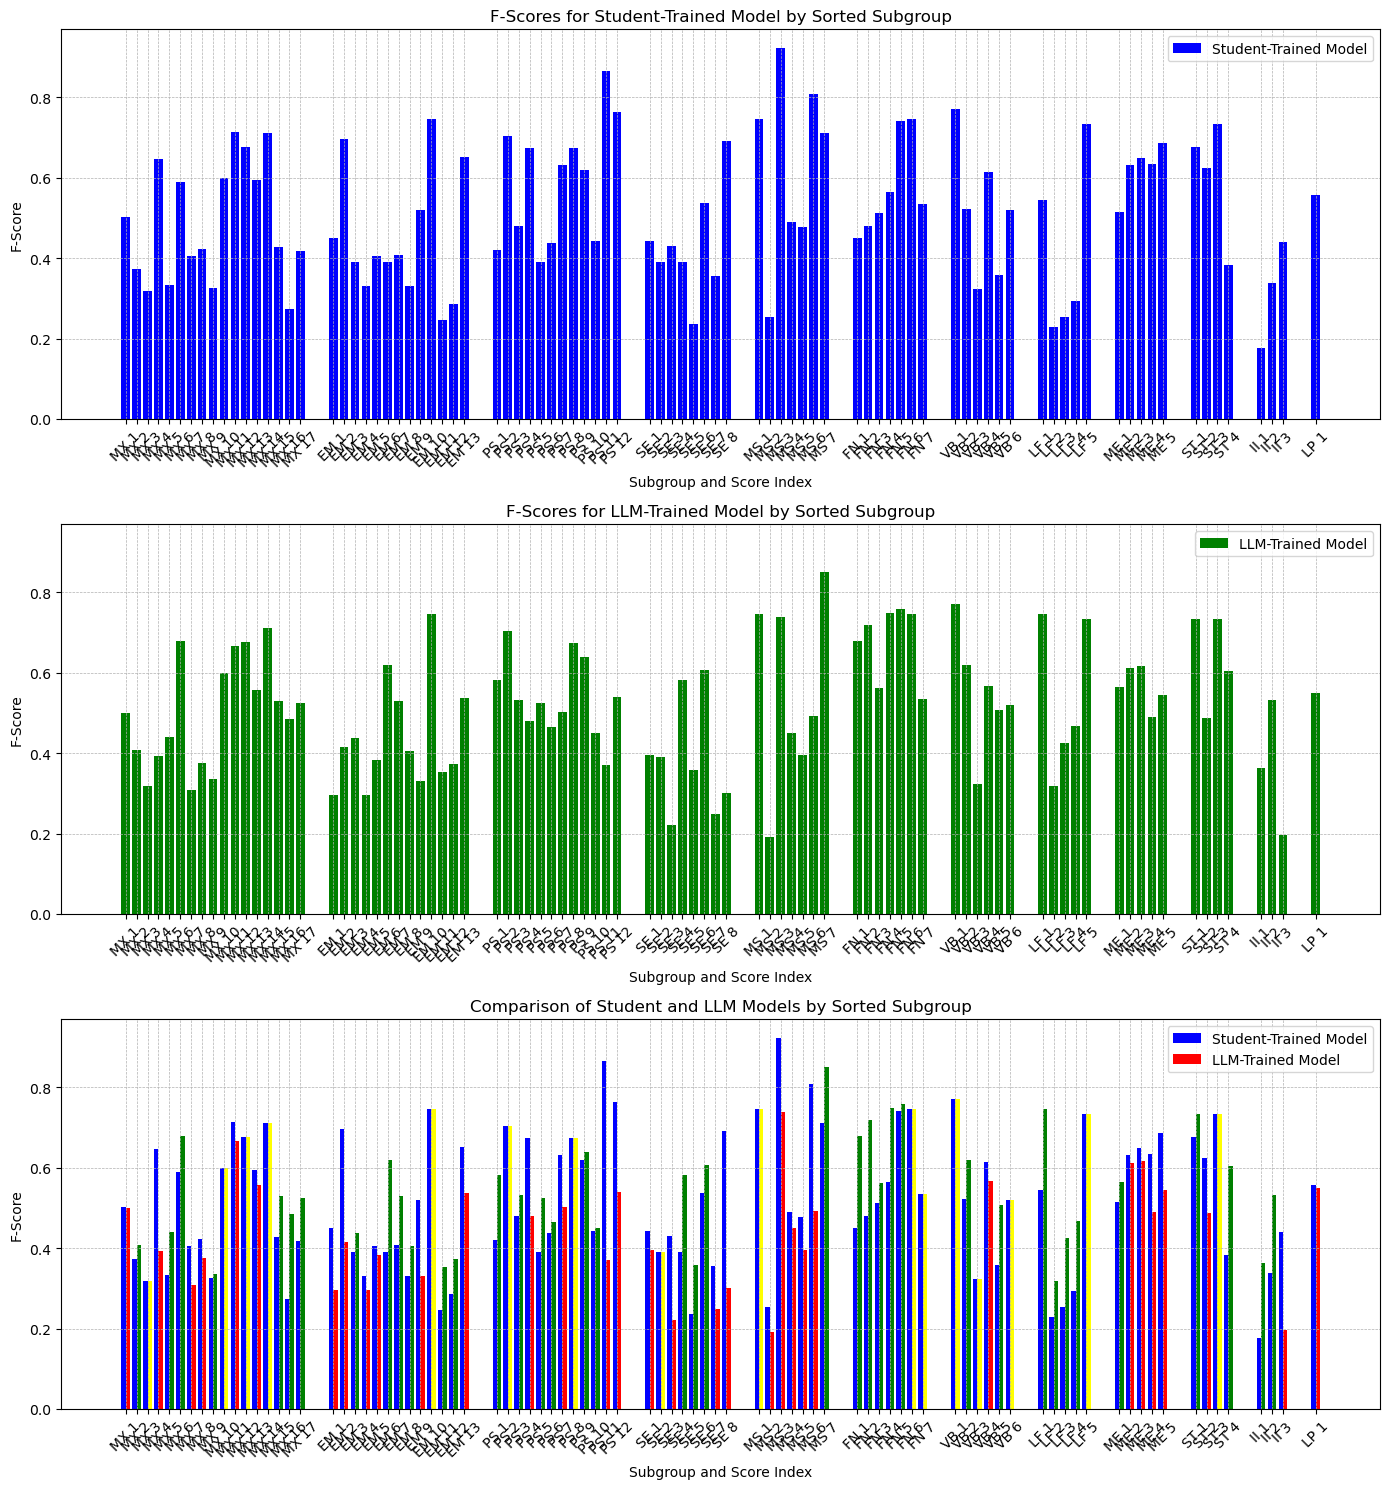

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import warnings

# sklearn-warnings unterdrücken
warnings.filterwarnings("ignore", category=UserWarning)

# Relative Pfade zu den Ordnern
student_data_folder = 'Data_SRA'  # Ordner mit TSV-Dateien
llm_data_folder = 'Data_LLM'      # Ordner mit CSV-Dateien

# Funktion zur Extraktion der Untergruppen
def extract_subgroup(file_name):
    match = re.search(r'prompt([A-Z]{2})', file_name)
    return match.group(1) if match else None

# Liste aller TSV-Dateien im Ordner 'Data_SRA'
student_data_files = [os.path.join(student_data_folder, file) for file in os.listdir(student_data_folder) if file.endswith('.tsv')]

# Liste aller CSV-Dateien im Ordner 'Data_LLM'
llm_data_files = [os.path.join(llm_data_folder, file) for file in os.listdir(llm_data_folder) if file.endswith('.csv')]

# Untergruppen extrahieren
student_subgroups = [extract_subgroup(file) for file in os.listdir(student_data_folder) if file.endswith('.tsv')]
llm_subgroups = [extract_subgroup(file) for file in os.listdir(llm_data_folder) if file.endswith('.csv')]

# Zähle die Häufigkeit der Untergruppen
student_subgroup_counts = pd.Series(student_subgroups).value_counts()
llm_subgroup_counts = pd.Series(llm_subgroups).value_counts()

# Sortiere die Untergruppen in absteigender Reihenfolge nach der Größe
sorted_subgroups = student_subgroup_counts.index.tolist()

# F-Scores für jede Untergruppe speichern
subgroup_f_scores_student = {}
subgroup_f_scores_llm = {}

for student_file, llm_file in zip(student_data_files, llm_data_files):
    # Daten laden
    data_student = pd.read_csv(student_file, sep="\t")  # TSV-Dateien
    data_llm = pd.read_csv(os.path.join(llm_data_folder, student_file.split('/')[-1][:-3] + 'csv'))

    # Text preprocessing und Vektorisierung
    vectorizer = TfidfVectorizer()
    X_student = vectorizer.fit_transform(data_student['AnswerText'])
    X_llm = vectorizer.transform(data_llm['AnswerText'])

    y_student = data_student['Score']
    y_llm = data_llm['Score']

    # Einzigartige Labels extrahieren
    all_labels = set(data_student['Score']).union(set(data_llm['Score']))
    sorted_labels = sorted(all_labels)
    label_mapping = {label: index for index, label in enumerate(sorted_labels)}

    # Label-Mapping anwenden
    y_student_mapped = y_student.map(label_mapping)
    y_llm_mapped = y_llm.map(label_mapping)

    # Teil 1: Trainieren auf Studentendaten, Testen auf Studentendaten mit Leave-One-Out
    loo = LeaveOneOut()

    predictions_student = []
    true_labels_student = []

    for train_index, test_index in loo.split(X_student):
        X_train, X_test = X_student[train_index], X_student[test_index]
        y_train, y_test = y_student_mapped.iloc[train_index], y_student_mapped.iloc[test_index]

        svm_model_student = SVC(kernel='rbf')
        svm_model_student.fit(X_train, y_train)
        y_pred = svm_model_student.predict(X_test)

        predictions_student.append(y_pred[0])
        true_labels_student.append(y_test.iloc[0])

    f1_student = f1_score(true_labels_student, predictions_student, average='weighted', zero_division=0)

    subgroup_key = extract_subgroup(student_file.split('/')[-1])
    if subgroup_key not in subgroup_f_scores_student:
        subgroup_f_scores_student[subgroup_key] = []
    subgroup_f_scores_student[subgroup_key].append(f1_student)

    # Teil 2: Trainieren auf LLM-Daten, Testen auf Studentendaten mit Leave-One-Out
    predictions_llm = []
    true_labels_llm = []

    for train_index, test_index in loo.split(X_student):
        X_train_llm, X_test = X_llm, X_student[test_index]
        y_train_llm, y_test = y_llm_mapped, y_student_mapped.iloc[test_index]

        svm_model_llm = SVC(kernel='rbf')
        svm_model_llm.fit(X_train_llm, y_train_llm)
        y_pred_llm = svm_model_llm.predict(X_test)

        predictions_llm.append(y_pred_llm[0])
        true_labels_llm.append(y_test.iloc[0])

    f1_llm = f1_score(true_labels_llm, predictions_llm, average='weighted', zero_division=0)

    if subgroup_key not in subgroup_f_scores_llm:
        subgroup_f_scores_llm[subgroup_key] = []
    subgroup_f_scores_llm[subgroup_key].append(f1_llm)

# Maximale Anzahl an Einträgen
gap_size = 2  # Abstand zwischen den Untergruppen

# Sortiere die F-Scores entsprechend der sortierten Untergruppen
sorted_student_scores = []
sorted_llm_scores = []
x_labels_comparison = []
index_counter = 0
indices_comparison = []

for key in sorted_subgroups:
    student_scores = subgroup_f_scores_student.get(key, [])
    llm_scores = subgroup_f_scores_llm.get(key, [])

    # Daten für den Vergleichsplot aufbereiten
    for idx, (student_score, llm_score) in enumerate(zip(student_scores, llm_scores)):
        sorted_student_scores.append(student_score)
        sorted_llm_scores.append(llm_score)
        x_labels_comparison.append(f'{key} {idx+1}')
        indices_comparison.append(index_counter)
        index_counter += 1
    index_counter += gap_size  # Lücke für die nächste Untergruppe

# Zwei separate Plots und ein Vergleichsplot erstellen
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15), sharey=True)

# Plot 1: Studententrainierte Modelle nach sortierten Untergruppen
ax1.bar(indices_comparison, sorted_student_scores, color='blue', label='Student-Trained Model')
ax1.set_xlabel('Subgroup and Score Index')
ax1.set_ylabel('F-Score')
ax1.set_title('F-Scores for Student-Trained Model by Sorted Subgroup')
ax1.set_xticks(indices_comparison)
ax1.set_xticklabels(x_labels_comparison, rotation=45)
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot 2: LLM-trainierte Modelle nach sortierten Untergruppen
ax2.bar(indices_comparison, sorted_llm_scores, color='green', label='LLM-Trained Model')
ax2.set_xlabel('Subgroup and Score Index')
ax2.set_ylabel('F-Score')
ax2.set_title('F-Scores for LLM-Trained Model by Sorted Subgroup')
ax2.set_xticks(indices_comparison)
ax2.set_xticklabels(x_labels_comparison, rotation=45)
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# Vergleichsplot 3: Unterschiedliche Balkenfarben für Differenzen
comparison_colors = []
for student_score, llm_score in zip(sorted_student_scores, sorted_llm_scores):
    if llm_score > student_score:
        comparison_colors.append('green')  # LLM-Wert ist höher
    elif llm_score < student_score:
        comparison_colors.append('red')  # LLM-Wert ist niedriger
    else:
        comparison_colors.append('yellow')  # Werte sind gleich

# Darstellung: Blauer Balken für Student-Werte und LLM-Werte daneben in verschiedenen Farben
ax3.bar(indices_comparison, sorted_student_scores, color='blue', width=0.4, label='Student-Trained Model')
ax3.bar([i + 0.4 for i in indices_comparison], sorted_llm_scores, color=comparison_colors, width=0.4, label='LLM-Trained Model')
ax3.set_xlabel('Subgroup and Score Index')
ax3.set_ylabel('F-Score')
ax3.set_title('Comparison of Student and LLM Models by Sorted Subgroup')
ax3.set_xticks([i + 0.2 for i in indices_comparison])
ax3.set_xticklabels(x_labels_comparison, rotation=45)
ax3.legend()
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


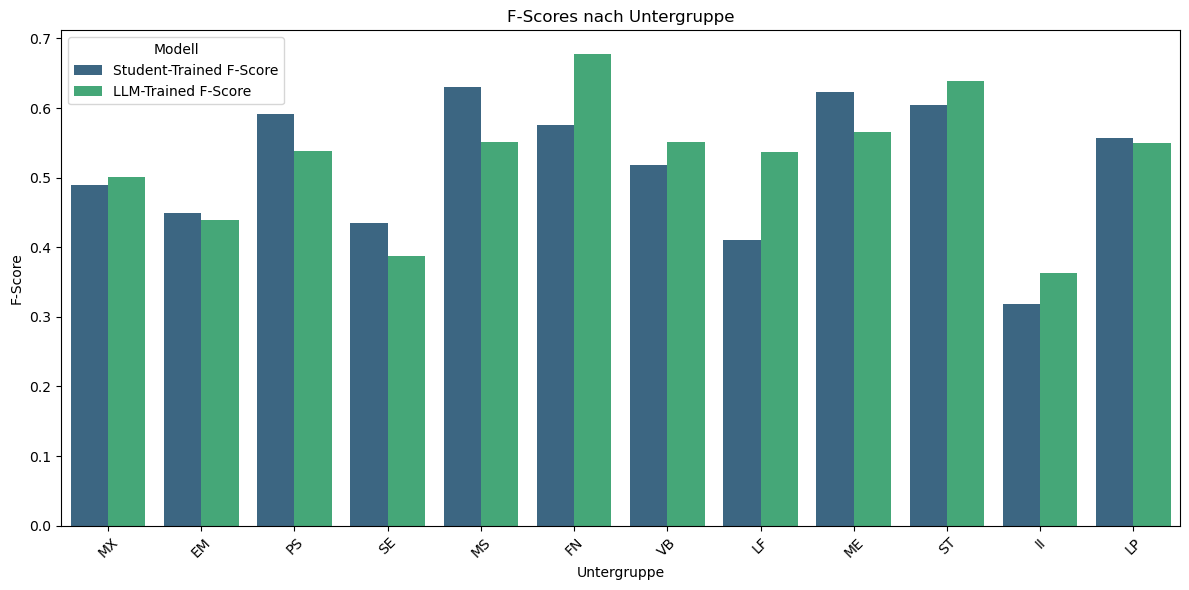

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Erstelle einen DataFrame für die F-Scores und Untergruppen
f_scores_df = pd.DataFrame({
    'Subgroup': sorted_subgroups,
    'Student-Trained F-Score': [np.mean(subgroup_f_scores_student.get(sub, [0])) for sub in sorted_subgroups],
    'LLM-Trained F-Score': [np.mean(subgroup_f_scores_llm.get(sub, [0])) for sub in sorted_subgroups],
    'Data Count': [student_subgroup_counts.get(sub, 0) for sub in sorted_subgroups]
})

# Visualisierung der F-Scores pro Untergruppe
plt.figure(figsize=(12, 6))
sns.barplot(data=f_scores_df.melt(id_vars='Subgroup', value_vars=['Student-Trained F-Score', 'LLM-Trained F-Score']),
            x='Subgroup', y='value', hue='variable', palette='viridis')
plt.title('F-Scores nach Untergruppe')
plt.ylabel('F-Score')
plt.xlabel('Untergruppe')
plt.xticks(rotation=45)
plt.legend(title='Modell')
plt.tight_layout()
plt.show()
